# Exercise

This episode of "time to get your hands dirty" is about gravitational-wave selection effects (LIGO interferometers).

In order to decide if a feature in the observed population of objects is telling us something new about reality, we need to understand and model our selection effects. In observational astronomy, this is known as Malmquist bias and was first formulated in 1922.

The goal here is to machine-learn the LIGO detectability: can we predict if a gravitational-wave source will be detected? This dataset contains simulated gravitational-wave signals from merging black holes. If you've never seen them, the .h5 format is a highly optimized storage strategy for large datasets. In python, you can read it with h5py. In particular, each source has the following features:

* $mtot$: the total mass of the binary.
* $q$: the mass ratio (it is such that $0<q\leq1$).
* $chi1x$, $chi1y$, $chi1z$, $chi2x$, $chi2y$, $chi2z$: the components of the black-hole spins in a suitable reference frame.
* $ra$, $dec$: the location of the source in the sky.
* $iota$: the inclination of the orbital plane.
* $psi$: the polarization angle (gravitational waves have two polarization states much like light).
* $z$: the redshift.

The detectability is defined using the $snr$ (signal-to-noise ratio). We threshold the $snr$ values and assume that LIGO will (not) see a source if $snr>12$ ($snr<12$). The resulting $0-1$ labels are reported in the $det$ attribute in the dataset ($0$ are the non-detectable sources, $1$ are the detectable sources). 

Today's task is to train a classifier (you decide which one!) and separate sources that are detectables from those that aren't.

##### Tips:

* You can downsample the data for debugging purposes.
* You can also use only some of the features.

### The best I could do...

Together with Alberto Vecchio and Geraint Prattent, I tackled this classification problem with neural networks: arXiv:2007.06585. In the paper we reached an accuracy (true positive + true negative / total) of $98.4 \%$. The data you're using are those of the green curve in Fig 2 of that paper. Could you do better?

### Another idea

Using the same data, we could run a regressor on $snr$ instead of a classifier on $det$. We can then threshold the predictions (instead of tresholding the data like we're doing now). Would this give a better performance?

How about trying to reduce the dimensionality of the dataset with a PCA-type algorithm to ease the classification problem?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import sklearn
import sklearn.model_selection
from sklearn.metrics import roc_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [2]:
data = h5py.File('/Users/beasa/Desktop/astrostatistics_bicocca_2024/solutions/sample_2e7_design_precessing_higherordermodes_3detectors.h5')

data

<HDF5 file "sample_2e7_design_precessing_higherordermodes_3detectors.h5" (mode r)>

In [3]:
print(data.keys())
print(data['chi2x'][:])

<KeysViewHDF5 ['chi1x', 'chi1y', 'chi1z', 'chi2x', 'chi2y', 'chi2z', 'dec', 'det', 'iota', 'mtot', 'psi', 'q', 'ra', 'snr', 'z']>
[-0.1611142   0.05753236 -0.21553765 ...  0.3057056   0.14565681
 -0.15248288]


I select $80.000$ data from the whole data set $data$, and I save the resulting points in $Data$. In addiction, I save in the array $y$ the values $0$ and $1$ linked to the signal-to-noise ratio $snr$. This is a binary classification problem because I associate to detectable sources ($snr>12$) the value $1$ and to non-detectable sources ($snr<12$) the value $0$. 

Consequently, I split the data set into training and validation sets.

In [4]:
length = 80000
Data = []

for variable in ['chi1x', 'chi1y', 'chi1z', 'chi2x', 'chi2y', 'chi2z', 'dec', 'iota', 'mtot', 'psi', 'q', 'ra', 'z']:
    Data.append(data[variable][:length])

Data = np.array(Data).T
y = np.array(data['det'][:length])

X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(Data, y, test_size=0.30, random_state=77)

To classify the detectable and the non-detectable sources I use Random Forest Classifier. To start, I initialize the method and I train the model with the training sets. Then, I compute the predictions and the probabilities on the validation sets, and the resulting false positive and true positive rate.

In [5]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

y_pred_rfc = rfc.predict(X_val)

yProb_rfc = rfc.predict_proba(X_val)[:, 1]

fpr_rfc, tpr_rfc, thresh_rfc = roc_curve(y_val, yProb_rfc)

For completeness, I try also with Boosting classification and I repeat the procedure shown above.

In [6]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)

y_pred_gbc = gbc.predict(X_val)

yProb_gbc = gbc.predict_proba(X_val)[:, 1]

fpr_gbc, tpr_gbc, thresh_gbc = roc_curve(y_val, yProb_gbc)

I plot the resulting ROC curves for the two models.

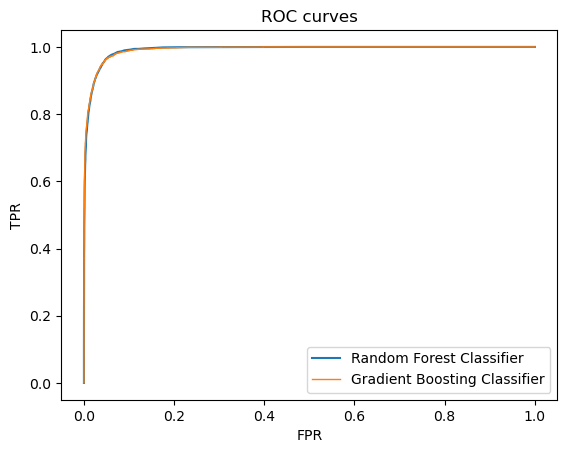

In [7]:
plt.plot(fpr_rfc, tpr_rfc, label='Random Forest Classifier')
plt.plot(fpr_gbc, tpr_gbc, label='Gradient Boosting Classifier', lw=1)
plt.legend()
plt.title('ROC curves')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

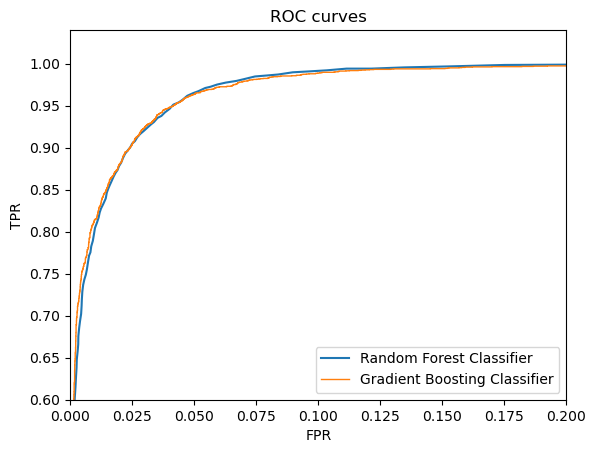

In [8]:
plt.plot(fpr_rfc, tpr_rfc, label='Random Forest Classifier')
plt.plot(fpr_gbc, tpr_gbc, label='Gradient Boosting Classifier', lw=1)
plt.legend(loc='lower right')
plt.title('ROC curves')
plt.ylim(0.6, 1.04)
plt.xlim(0, 0.2)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

I want to compare the numbers. Therefore, I compute the confusion matrix for bothe the classifiers, and the corresponding number of false negatives, false positives, true negatives and true positives.

In [9]:
C_rfc = sklearn.metrics.confusion_matrix(y_val, y_pred_rfc)
C_gbc = sklearn.metrics.confusion_matrix(y_val, y_pred_gbc)

falseNeg_rfc = C_rfc[1, 0]
falseNeg_gbc = C_gbc[1, 0]
falsePos_rfc = C_rfc[0, 1]
falsePos_gbc = C_gbc[0, 1]

trueNeg_rfc = C_rfc[0, 0]
trueNeg_gbc = C_gbc[0, 0]
truePos_rfc = C_rfc[1, 1]
truePos_gbc = C_gbc[1, 1]

print(f'False negatives RFC: {falseNeg_rfc}     False positives RFC: {falsePos_rfc}')
print(f'False negatives GBC: {falseNeg_gbc}     False positives GBC: {falsePos_gbc}')
print('Total number of test sources: ', np.sum(C_rfc))  # it is the 30% of 80.000 (check)

False negatives RFC: 526     False positives RFC: 303
False negatives GBC: 515     False positives GBC: 297
Total number of test sources:  24000


##### Compute the accuracy

The accuracy is defined to be the ratio between (true negatives + true positives) and the total number of sources. For the two classifiers:

In [10]:
acc_rfc = (trueNeg_rfc+truePos_rfc)/np.sum(C_rfc)
acc_gbc = (trueNeg_gbc+truePos_gbc)/np.sum(C_gbc)

print(f'Accuracy RFC: {acc_rfc*100:.3f}%')
print(f'Accuracy GBC: {acc_gbc*100:.3f}%')

Accuracy RFC: 96.546%
Accuracy GBC: 96.617%
